In [24]:
import colorsys
import pathlib
from typing import Any, Dict, List, Optional, Tuple, Set
import itertools # Added for combinations

import matplotlib.pyplot as plt
import numpy as np
import torch
import umap  # type: ignore
from mmengine.fileio import load
from hod.utils.tree import HierarchyNode, HierarchyTree
from scipy.spatial import ConvexHull, QhullError # Added QhullError
from adjustText import adjust_text # Added for non-overlapping text
from scipy.stats import spearmanr # Added for correlation
from matplotlib.lines import Line2D # Added for legend
from matplotlib.patches import Patch # Added for legend
import matplotlib.colors as mcolors # Added for legend & colorbar
from matplotlib.figure import Figure
from matplotlib.axes import Axes


# import seaborn as sns
# sns.set_theme(style='white')

ann_file = "../data/aircraft/hierarchical/aircraft_test.json"

# -----------------------------------------------------------------------------
# Colour utilities
# -----------------------------------------------------------------------------

def build_hue_map(root: HierarchyNode, shrink: float = 0.8) -> Dict[str, float]:
    """
    Assign hues so siblings at shallow levels get strong separation.
    `shrink < 1` compresses the span passed down to each generation.
    """
    hue_map: Dict[str, float] = {}

    def _recurse(node: HierarchyNode, start: float, end: float, depth: int) -> None:
        hue_map[node.name] = (start + end) / 2
        if not node.children:
            return

        usable_span = (end - start) * (1.0 if depth == 0 else shrink)
        left_gap = ((end - start) - usable_span) / 2
        span_start = start + left_gap
        width = usable_span / len(node.children)

        sorted_children = sorted(node.children, key=lambda x: x.original_sort_key if hasattr(x, 'original_sort_key') else x.name)

        for idx, child in enumerate(sorted_children):
            cs = span_start + idx * width
            ce = cs + width
            _recurse(child, cs, ce, depth + 1)

    _recurse(root, 0.0, 1.0, 0)
    return hue_map


# -----------------------------------------------------------------------------
# UMAP Plotting Helper Functions
# -----------------------------------------------------------------------------

def _load_data_and_prepare_umap(
    model_path: pathlib.Path | str, 
    ann_file_path: pathlib.Path | str, 
    random_state: int = 42
) -> Tuple[Optional[np.ndarray], Optional[HierarchyTree], Optional[Dict[str, float]], Optional[List[str]], Optional[Dict[str, np.ndarray]], Optional[Set[str]], Optional[np.ndarray], Optional[List[Dict[str, Any]]]]:
    """Loads embeddings, taxonomy, performs UMAP, and prepares initial data structures."""
    try:
        model_path_obj = pathlib.Path(model_path)
        ann_file_path_obj = pathlib.Path(ann_file_path)

        if not model_path_obj.exists():
            print(f"Error: Model file not found at '{model_path_obj}'")
            return None, None, None, None, None, None, None, None
        if not ann_file_path_obj.exists():
            print(f"Error: Annotation file not found at '{ann_file_path_obj}'")
            return None, None, None, None, None, None, None, None

        state = torch.load(model_path_obj, map_location="cpu", weights_only=False)
        if "state_dict" in state:
            state = state["state_dict"]
        
        embeddings_key = "bbox_head.cls_branches.0.embeddings"
        if embeddings_key not in state:
            print(f"Error: Embeddings key '{embeddings_key}' not found in model state_dict.")
            return None, None, None, None, None, None, None, None
            
        embeddings_tensor = state[embeddings_key].detach().cpu()
        embeddings = embeddings_tensor.numpy()

        ann = load(ann_file_path_obj)
        if not isinstance(ann, dict) or "categories" not in ann or "taxonomy" not in ann:
            print("Error: Annotation file is missing 'categories' or 'taxonomy' keys, or is not a dictionary.")
            return None, None, None, None, None, None, None, None
        
        categories = ann["categories"]
        if not isinstance(categories, list) or not all(isinstance(cat, dict) and "name" in cat for cat in categories):
            print("Error: 'categories' must be a list of dictionaries, each with a 'name' key.")
            return None, None, None, None, None, None, None, None

        if len(embeddings) != len(categories):
            print(
                f"Warning: Number of embeddings ({len(embeddings)}) does not match number of "
                f"categories ({len(categories)}). Some categories might be missing embeddings."
            )

        reducer = umap.UMAP(random_state=random_state, n_neighbors=min(15, len(embeddings)-1 if len(embeddings) > 1 else 1), min_dist=0.1, metric='euclidean')
        umap_2d: np.ndarray = reducer.fit_transform(embeddings)

        labels: List[str] = [cat["name"] for cat in categories]
        hierarchy = HierarchyTree(ann["taxonomy"])
        hue_map = build_hue_map(hierarchy.root)

        label_to_idx = {name: i for i, name in enumerate(labels)}
        
        node_name_to_umap_coords = {}
        for name in labels:
            if name in label_to_idx and name in hierarchy.class_to_node:
                idx = label_to_idx[name]
                if idx < len(umap_2d):
                    node_name_to_umap_coords[name] = umap_2d[idx]
                # else:
                #     print(f"Warning: Index for label '{name}' ({idx}) is out of bounds for UMAP results (len: {len(umap_2d)}). Skipping.")
            # else:
            #     print(f"Warning: Label '{name}' not found in hierarchy or label_to_idx. Skipping UMAP coord assignment.")


        plotted_node_names = set(node_name_to_umap_coords.keys())

        if not plotted_node_names:
            print("Error: No nodes to plot after UMAP transformation and filtering. Check if labels match taxonomy and embeddings.")
            return None, None, None, None, None, None, None, None

        return embeddings, hierarchy, hue_map, labels, node_name_to_umap_coords, plotted_node_names, umap_2d, categories

    except FileNotFoundError: # Should be caught by explicit checks above, but as a fallback.
        print(f"Error: Model or annotation file not found. Searched for model: '{model_path}', ann: '{ann_file_path}'")
        return None, None, None, None, None, None, None, None
    except QhullError as qe: # UMAP can sometimes raise this
        print(f"QhullError during UMAP processing: {qe}. This might be due to the data structure.")
        return None, None, None, None, None, None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during data loading and UMAP preparation: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None, None, None


def _calculate_visual_attributes(
    hierarchy: HierarchyTree, 
    plotted_node_names: Set[str], 
    node_name_to_umap_coords: Dict[str, np.ndarray],
    all_labels_from_ann: List[str], 
    hue_map: Dict[str, float], 
    depth_cmap
) -> Tuple[Optional[List[str]], Optional[np.ndarray], Optional[np.ndarray], Optional[List[Any]], Optional[List[Any]], Optional[int], Optional[int], float, float, Optional[np.ndarray]]:
    """Calculates marker sizes, colors, and filters data for plotting."""
    
    depths_values: List[int] = []
    for name in plotted_node_names:
        node = hierarchy.class_to_node.get(name)
        if node:
            depths_values.append(node.get_depth())
    min_depth = min(depths_values) if depths_values else 0
    max_depth = max(depths_values) if depths_values else 0

    node_subtree_sizes: Dict[str, int] = {}
    for name in plotted_node_names:
        node = hierarchy.class_to_node.get(name)
        if node:
            descendants = node.descendants()
            node_subtree_sizes[name] = len(descendants) + 1
        else:
            node_subtree_sizes[name] = 1 
    
    # Filter labels and umap_2d coordinates based on plotted_node_names
    # This ensures consistency if some labels were dropped
    filtered_labels_for_plot = [name for name in all_labels_from_ann if name in plotted_node_names]
    if not filtered_labels_for_plot:
        print("Warning: No labels left after filtering for plotted nodes. Cannot calculate visual attributes.")
        return None, None, None, None, None, 0, 0, 0.0, 0.0, None
        
    filtered_umap_coords_for_plot = np.array([node_name_to_umap_coords[name] for name in filtered_labels_for_plot])
    
    marker_s_values_raw = np.array([node_subtree_sizes.get(name, 1) for name in filtered_labels_for_plot])

    min_marker_s_const = 20.0
    max_marker_s_const = 180.0
    
    marker_sizes_arr: np.ndarray
    if marker_s_values_raw.size > 0 and np.max(marker_s_values_raw) > np.min(marker_s_values_raw):
        log_s = np.log1p(marker_s_values_raw - np.min(marker_s_values_raw))
        if np.max(log_s) > 0: 
            norm_s = (log_s - np.min(log_s)) / np.max(log_s)
        else:
            norm_s = np.zeros_like(log_s)
        marker_sizes_arr = norm_s * (max_marker_s_const - min_marker_s_const) + min_marker_s_const
    elif marker_s_values_raw.size > 0: 
        marker_sizes_arr = np.full(len(marker_s_values_raw), (min_marker_s_const + max_marker_s_const) / 2)
    else: 
        marker_sizes_arr = np.array([])

    fill_colors_list_rgb = []
    edge_colors_list_rgb = []

    for name in filtered_labels_for_plot:
        node = hierarchy.class_to_node.get(name)
        
        hue_val = 0.0 # Default hue
        if node and node.parent and node.parent.name in hue_map:
            hue_val = hue_map[node.parent.name]
        elif node and node.name in hue_map: # For root or nodes whose parents are not in hue_map
            hue_val = hue_map[node.name]
        fill_colors_list_rgb.append(colorsys.hls_to_rgb(hue_val, 0.65, 0.85))

        norm_depth = 0.5 # Default normalized depth
        if node:
            current_depth = node.get_depth()
            if max_depth > min_depth:
                norm_depth = (current_depth - min_depth) / (max_depth - min_depth)
            elif max_depth == min_depth and max_depth > 0: # all nodes at same depth > 0
                 norm_depth = 0.5 
            # else all nodes at depth 0 or no nodes, norm_depth remains 0.5 (mid-color)
        edge_colors_list_rgb.append(depth_cmap(norm_depth))
            
    return filtered_labels_for_plot, filtered_umap_coords_for_plot, marker_sizes_arr, fill_colors_list_rgb, edge_colors_list_rgb, min_depth, max_depth, min_marker_s_const, max_marker_s_const, marker_s_values_raw


def _plot_scatter_and_labels(
    ax: Axes, 
    filtered_umap_coords: np.ndarray, 
    marker_sizes_arr: np.ndarray, 
    fill_colors_list_rgb: List[Any], 
    edge_colors_list_rgb: List[Any], 
    filtered_labels: List[str]
):
    """Plots UMAP scatter points and their labels."""
    if filtered_umap_coords.size == 0 or marker_sizes_arr.size == 0:
        print("Warning: No data points to scatter plot.")
        return

    ax.scatter(
        filtered_umap_coords[:, 0], filtered_umap_coords[:, 1],
        s=marker_sizes_arr,
        c=fill_colors_list_rgb,
        edgecolors=edge_colors_list_rgb,
        linewidths=1.5,
        alpha=0.8,
        zorder=2
    )

    texts = []
    for i, ((x, y), lbl) in enumerate(zip(filtered_umap_coords, filtered_labels)):
        current_marker_size = marker_sizes_arr[i] if i < len(marker_sizes_arr) else np.mean(marker_sizes_arr) if len(marker_sizes_arr) > 0 else 20
        font_size_val = max(6, 12 - 0.1 * np.sqrt(current_marker_size)) # Heuristic for font size
        
        # Ensure edge color is valid
        edge_color_val = edge_colors_list_rgb[i] if i < len(edge_colors_list_rgb) else 'black'

        texts.append(ax.text(
            x, y, lbl,
            color=edge_color_val, 
            fontsize=font_size_val, 
            ha="center", va="center",
            alpha=0.9, weight="normal",
            zorder=3
        ))
    
    if texts:
        try:
            adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5))
        except Exception as e:
            print(f"Could not adjust texts: {e}")


def _plot_taxonomy_skeleton(
    ax: Axes, 
    plotted_node_names: Set[str], 
    hierarchy: HierarchyTree, 
    node_name_to_umap_coords: Dict[str, np.ndarray]
):
    """Overlays the taxonomy skeleton on the plot."""
    for node_name in plotted_node_names:
        node = hierarchy.class_to_node.get(node_name)
        if node and node.parent and node.parent.name in plotted_node_names:
            if node.parent.name in node_name_to_umap_coords and node.name in node_name_to_umap_coords:
                parent_coords = node_name_to_umap_coords[node.parent.name]
                child_coords = node_name_to_umap_coords[node.name]
                ax.plot(
                    [parent_coords[0], child_coords[0]],
                    [parent_coords[1], child_coords[1]],
                    color='lightgrey', linewidth=1.0, alpha=0.3, zorder=1
                )

def _plot_convex_hulls_and_parent_labels(
    ax: Axes, 
    plotted_node_names: Set[str], 
    hierarchy: HierarchyTree, 
    node_name_to_umap_coords: Dict[str, np.ndarray], 
    hue_map: Dict[str, float]
):
    """Plots convex hulls for parent groups and labels them."""
    parent_names_for_hulls = set()
    for node_name in plotted_node_names:
        node = hierarchy.class_to_node.get(node_name)
        if not node: continue

        # A node can be a "parent" for hull drawing if it has children that are plotted
        if node.children and any(child.name in plotted_node_names for child in node.children):
            parent_names_for_hulls.add(node.name)

    for parent_name in parent_names_for_hulls:
        parent_node = hierarchy.class_to_node.get(parent_name)
        if not parent_node: continue

        child_coords_for_hull = []
        for child_node in parent_node.children:
            if child_node.name in node_name_to_umap_coords: # Child must be in the plotted set
                child_coords_for_hull.append(node_name_to_umap_coords[child_node.name])
        
        if len(child_coords_for_hull) >= 3: # Need at least 3 points for a hull
            points = np.array(child_coords_for_hull)
            try:
                hull = ConvexHull(points)
                parent_hue = hue_map.get(parent_name, 0.0) # Default hue if parent not in map
                
                hull_fill_color_rgb = colorsys.hls_to_rgb(parent_hue, 0.85, 0.9)
                hull_edge_color_rgb = colorsys.hls_to_rgb(parent_hue, max(0, 0.85 * 0.6), 0.9)

                ax.fill(
                    points[hull.vertices, 0], points[hull.vertices, 1],
                    facecolor=hull_fill_color_rgb, alpha=0.15, 
                    edgecolor=hull_edge_color_rgb, linewidth=1.0, zorder=0
                )
                
                text_x = np.mean(points[hull.vertices, 0])
                text_y = np.mean(points[hull.vertices, 1])
                text_color_rgb = colorsys.hls_to_rgb(parent_hue, 0.3, 0.7) 
                ax.text(text_x, text_y, parent_name,
                        fontsize=9, color=text_color_rgb, alpha=0.7,
                        ha='center', va='center', weight='bold', zorder=0.5)
            except QhullError:
                # print(f"QhullError: Could not compute convex hull for parent '{parent_name}'. Skipping hull.")
                pass 
            except Exception as e:
                print(f"Error plotting hull for '{parent_name}': {e}")


def _add_umap_legend(
    fig: Figure, 
    ax: Axes, 
    min_depth: int, 
    max_depth: int, 
    depth_cmap, 
    marker_s_values_raw: Optional[np.ndarray], 
    min_marker_s_const: float, 
    max_marker_s_const: float
):
    """Adds a comprehensive legend to the UMAP plot."""
    legend_elements = [Patch(facecolor='gray', alpha=0.65, label='Fill: Parent Semantic Group (Hue)')]

    norm_for_cb = mcolors.Normalize(vmin=min_depth, vmax=max_depth if max_depth > min_depth else min_depth + 1)
    sm = plt.cm.ScalarMappable(cmap=depth_cmap, norm=norm_for_cb)
    sm.set_array([]) 
    
    try: # Add colorbar in a robust way
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
        cbar.set_label('Hierarchy Depth (Edge Color)', rotation=270, labelpad=15, fontsize=10)
        cbar.ax.tick_params(labelsize=8)
    except Exception as e:
        print(f"Could not add colorbar to legend: {e}")


    if marker_s_values_raw is not None and marker_s_values_raw.size > 0:
        min_raw_val = np.min(marker_s_values_raw)
        max_raw_val = np.max(marker_s_values_raw)
        median_raw_val = np.median(marker_s_values_raw)

        legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                   label=f'Size: Subtree (Smallest ~{int(min_raw_val)})',
                                   markerfacecolor='grey', markersize=np.sqrt(min_marker_s_const)))
        
        # Determine label for medium size point
        medium_label_val_str = ""
        if min_raw_val == max_raw_val: # All same size
            pass # No medium needed
        elif median_raw_val != min_raw_val and median_raw_val != max_raw_val:
             medium_label_val_str = f"~{int(median_raw_val)}"
        else: # Median is same as min or max, pick a value in between
            medium_label_val_str = f"~{int((min_raw_val + max_raw_val) / 2)}"
        
        if medium_label_val_str: # Only add if distinct and meaningful
             avg_marker_plot_size = (min_marker_s_const + max_marker_s_const) / 2
             legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                   label=f'Size: Subtree (Medium {medium_label_val_str})',
                                   markerfacecolor='grey', markersize=np.sqrt(avg_marker_plot_size)))

        legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                   label=f'Size: Subtree (Largest ~{int(max_raw_val)})',
                                   markerfacecolor='grey', markersize=np.sqrt(max_marker_s_const)))
    else:
         legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                   label='Size: Subtree Size (N/A)',
                                   markerfacecolor='grey', markersize=np.sqrt((min_marker_s_const + max_marker_s_const)/2)))

    legend_elements.append(Line2D([0], [0], color='lightgrey', lw=1, label='Taxonomy Edge'))
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=9, title="Legend", title_fontsize=11)


# -----------------------------------------------------------------------------
# Main UMAP Plotting logic
# -----------------------------------------------------------------------------

def plot_embeddings_umap(model_path: pathlib.Path | str, ann_file_path: pathlib.Path | str, *, random_state: int = 42) -> None:
    """Project the classifier embeddings with UMAP and enhance visualization using helper functions."""

    loaded_data = _load_data_and_prepare_umap(model_path, ann_file_path, random_state)
    if loaded_data[0] is None or loaded_data[1] is None or loaded_data[2] is None or loaded_data[3] is None or loaded_data[4] is None or loaded_data[5] is None:
        print(f"Halting UMAP plot for '{model_path}' due to critical data loading/preparation errors.")
        return
    
    _embeddings, hierarchy, hue_map, labels_from_ann, node_name_to_umap_coords, plotted_node_names, _umap_2d, _ann_categories = loaded_data
    
    # Ensure all required outputs from _load_data_and_prepare_umap are valid (redundant with above but good practice)
    if not all(val is not None for val in [hierarchy, hue_map, labels_from_ann, node_name_to_umap_coords, plotted_node_names]):
        print(f"Halting UMAP plot for '{model_path}' due to missing critical data after loading (secondary check).")
        return

    depth_cmap = plt.get_cmap('cividis_r') # CVD-friendly

    visual_attrs = _calculate_visual_attributes(
        hierarchy, plotted_node_names, node_name_to_umap_coords, labels_from_ann, hue_map, depth_cmap
    )
    if visual_attrs[0] is None or visual_attrs[1] is None or visual_attrs[2] is None: # Check key attributes like filtered_labels, coords, sizes
         print(f"Halting UMAP plot for '{model_path}' due to errors in calculating visual attributes.")
         return

    (filtered_labels_for_plot, filtered_umap_coords_for_plot, marker_sizes_arr, 
     fill_colors_list_rgb, edge_colors_list_rgb, min_depth, max_depth, 
     min_marker_s_const, max_marker_s_const, marker_s_values_raw) = visual_attrs

    if filtered_umap_coords_for_plot is None or marker_sizes_arr is None or not filtered_labels_for_plot:
        print(f"Halting UMAP plot: Not enough data to plot after calculating visual attributes for '{model_path}'.")
        return
    if filtered_umap_coords_for_plot.shape[0] == 0:
        print(f"Halting UMAP plot: Zero data points after processing for '{model_path}'.")
        return


    fig, ax = plt.subplots(figsize=(16, 16))

    _plot_scatter_and_labels(ax, filtered_umap_coords_for_plot, marker_sizes_arr, fill_colors_list_rgb, edge_colors_list_rgb, filtered_labels_for_plot)
    _plot_taxonomy_skeleton(ax, plotted_node_names, hierarchy, node_name_to_umap_coords)
    _plot_convex_hulls_and_parent_labels(ax, plotted_node_names, hierarchy, node_name_to_umap_coords, hue_map)

    ax.set_title(f"UMAP Projection of Classifier Embeddings\nModel: {pathlib.Path(model_path).name}", fontsize=16)
    ax.set_xlabel("UMAP-1", fontsize=12)
    ax.set_ylabel("UMAP-2", fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    
    _add_umap_legend(fig, ax, min_depth, max_depth, depth_cmap, marker_s_values_raw, min_marker_s_const, max_marker_s_const)

    fig.tight_layout(rect=[0, 0, 0.9, 1]) 
    plt.show()


# -----------------------------------------------------------------------------
# Distance Correlation Plotting Helper Functions
# -----------------------------------------------------------------------------

def _get_path_to_root(node: HierarchyNode) -> List[HierarchyNode]:
    path = []
    curr: Optional[HierarchyNode] = node
    while curr:
        path.append(curr)
        curr = curr.parent
    return path[::-1]

def _get_lca(node1: HierarchyNode, node2: HierarchyNode) -> Optional[HierarchyNode]:
    if node1 is None or node2 is None: return None
    path1 = _get_path_to_root(node1)
    path2 = _get_path_to_root(node2)
    
    lca_node: Optional[HierarchyNode] = None
    for n1, n2 in zip(path1, path2):
        if n1 == n2: lca_node = n1
        else: break
    return lca_node

def _get_tree_distance(node1: HierarchyNode, node2: HierarchyNode) -> Optional[int]:
    if node1 == node2: return 0
    lca = _get_lca(node1, node2)
    if lca is None: return None 
    return node1.get_depth() + node2.get_depth() - 2 * lca.get_depth()

def _load_and_prepare_distance_data(
    model_path: pathlib.Path | str, 
    ann_file_path: pathlib.Path | str
) -> Tuple[Optional[torch.Tensor], Optional[HierarchyTree], Optional[Dict[str, float]], Optional[List[str]], Optional[Dict[str, int]]]:
    """Loads embeddings, hierarchy, and prepares data for distance calculations."""
    try:
        model_path_obj = pathlib.Path(model_path)
        ann_file_path_obj = pathlib.Path(ann_file_path)

        if not model_path_obj.exists():
            print(f"Error: Model file not found at '{model_path_obj}'")
            return None, None, None, None, None
        if not ann_file_path_obj.exists():
            print(f"Error: Annotation file not found at '{ann_file_path_obj}'")
            return None, None, None, None, None

        state = torch.load(model_path_obj, map_location="cpu", weights_only=False)
        if "state_dict" in state: state = state["state_dict"]
        
        embeddings_key = "bbox_head.cls_branches.0.embeddings"
        if embeddings_key not in state:
            print(f"Error: Embeddings key '{embeddings_key}' not found in model state_dict.")
            return None, None, None, None, None
        embeddings_tensor = state[embeddings_key].detach().cpu()

        ann_data = load(ann_file_path_obj)
        if not isinstance(ann_data, dict) or "categories" not in ann_data or "taxonomy" not in ann_data:
            print("Error: Annotation file is missing 'categories' or 'taxonomy', or is not a dict.")
            return None, None, None, None, None
        
        categories = ann_data["categories"]
        if not isinstance(categories, list) or not all(isinstance(cat, dict) and "name" in cat for cat in categories):
            print("Error: 'categories' must be a list of dicts, each with a 'name' key.")
            return None, None, None, None, None

        hierarchy = HierarchyTree(ann_data["taxonomy"])
        hue_map = build_hue_map(hierarchy.root)
        
        class_names_from_ann: List[str] = [cat["name"] for cat in categories]
        label_to_idx: Dict[str, int] = {name: i for i, name in enumerate(class_names_from_ann)}
        
        # Filter for valid class names present in embeddings, hierarchy, and with valid indices
        valid_class_names: List[str] = []
        for name in class_names_from_ann:
            idx = label_to_idx.get(name)
            if idx is not None and name in hierarchy.class_to_node and idx < embeddings_tensor.shape[0]:
                valid_class_names.append(name)
            # else:
            #     print(f"Warning (Distance Plot): Class '{name}' skipped. Missing in hierarchy, label_to_idx, or embeddings index out of bounds.")

        if len(valid_class_names) < 2:
            print(f"Not enough valid classes ({len(valid_class_names)}) with embeddings to calculate pairwise distances for '{model_path}'. Need at least 2.")
            return None, None, None, None, None
            
        return embeddings_tensor, hierarchy, hue_map, valid_class_names, label_to_idx

    except FileNotFoundError:
        print(f"Error: Model or annotation file not found. Searched for model: '{model_path}', ann: '{ann_file_path}'")
        return None, None, None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during data loading for distance correlation: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None

def _calculate_distances_and_colors(
    embeddings_tensor: torch.Tensor,
    hierarchy: HierarchyTree,
    hue_map: Dict[str, float],
    valid_class_names: List[str],
    label_to_idx: Dict[str, int]
) -> Tuple[List[int], List[float], List[Tuple[float, float, float]]]:
    """Calculates tree distances, Euclidean distances, and point colors."""
    tree_distances: List[int] = []
    euclidean_distances: List[float] = []
    point_colors_rgb: List[Tuple[float, float, float]] = []

    for name1, name2 in itertools.combinations(valid_class_names, 2):
        node1 = hierarchy.class_to_node.get(name1)
        node2 = hierarchy.class_to_node.get(name2)

        if node1 is None or node2 is None: continue # Should not happen if valid_class_names is correct

        tree_dist = _get_tree_distance(node1, node2)
        if tree_dist is None: continue
            
        idx1, idx2 = label_to_idx[name1], label_to_idx[name2]
        emb1, emb2 = embeddings_tensor[idx1], embeddings_tensor[idx2]
        euclidean_dist = torch.norm(emb1 - emb2).item()
        
        tree_distances.append(tree_dist)
        euclidean_distances.append(euclidean_dist)

        lca = _get_lca(node1, node2)
        current_hue = 0.0 
        if lca:
            # Prefer LCA's parent for hue, fallback to LCA itself, then default
            if lca.parent and lca.parent.name in hue_map:
                current_hue = hue_map[lca.parent.name]
            elif lca.name in hue_map: 
                current_hue = hue_map[lca.name]
        point_colors_rgb.append(colorsys.hls_to_rgb(current_hue, 0.65, 0.85))
    
    return tree_distances, euclidean_distances, point_colors_rgb

# -----------------------------------------------------------------------------
# Main Distance Correlation Plotting logic
# -----------------------------------------------------------------------------

def plot_distance_correlation(model_path: pathlib.Path | str, ann_file_path: pathlib.Path | str) -> None:
    """
    Plots correlation between tree-edge and Euclidean distances.
    Points colored by LCA's semantic group. Y-axis log-scaled.
    """
    loaded_data = _load_and_prepare_distance_data(model_path, ann_file_path)
    if not all(loaded_data): # Check if any element in tuple is None
        print(f"Halting distance correlation plot for '{model_path}' due to data loading errors.")
        return
    
    embeddings_tensor, hierarchy, hue_map, valid_class_names, label_to_idx = loaded_data
    # Further explicit None checks for type safety, though covered by `all()`
    if embeddings_tensor is None or hierarchy is None or hue_map is None or not valid_class_names or label_to_idx is None:
        print(f"Halting distance correlation plot for '{model_path}' due to missing critical data after loading (secondary check).")
        return


    tree_distances, euclidean_distances, point_colors_rgb = _calculate_distances_and_colors(
        embeddings_tensor, hierarchy, hue_map, valid_class_names, label_to_idx
    )

    if not tree_distances or not euclidean_distances:
        print(f"No valid distance pairs were calculated for '{model_path}'. Cannot plot correlation.")
        return

    rho = np.nan
    if len(tree_distances) >= 2 and len(euclidean_distances) >= 2:
        # Check for zero variance, which causes spearmanr to warn or error
        if np.std(tree_distances) > 0 and np.std(euclidean_distances) > 0:
            try:
                rho, _ = spearmanr(tree_distances, euclidean_distances)
            except ValueError as ve:
                print(f"Could not calculate Spearman correlation: {ve}") # e.g. if NaNs are present
        # else:
        #     print("Warning: Zero variance in tree or Euclidean distances. Spearman correlation is NaN.")
    # else:
    #     print("Warning: Not enough data points (<2) to calculate Spearman correlation.")


    fig, ax = plt.subplots(figsize=(10, 7)) 
    ax.scatter(tree_distances, euclidean_distances, 
               alpha=0.4, 
               edgecolors='k', 
               linewidths=0.3, 
               c=point_colors_rgb if point_colors_rgb else None) 
    
    ax.set_yscale('log') 
    ax.set_xlabel("Tree-edge distance", fontsize=12)
    ax.set_ylabel("Euclidean distance in embedding space (log scale)", fontsize=12) 
    
    model_name = pathlib.Path(model_path).name
    title_rho = f"Spearman ρ: {rho:.3f}" if not np.isnan(rho) else "Spearman ρ: N/A"
    ax.set_title(f"Embedding Distance vs. Tree Distance\nModel: {model_name}\n{title_rho}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7, which='both') 

    fig.tight_layout()
    plt.show()

# Example usage (ensure ann_file is correctly defined or passed directly)
# model_checkpoint_path = "../work_dirs/rtmdet_tiny_8xb32-300e_coco_recycle_pretrain_hierarchical_softmax_ohem_transformer_ep50/epoch_50.pth"
# plot_embeddings_umap(model_checkpoint_path, ann_file)
# plot_distance_correlation(model_checkpoint_path, ann_file)



/home/gonem/.conda/envs/tno/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/gonem/.conda/envs/tno/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_2234285/988550987.py:466: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


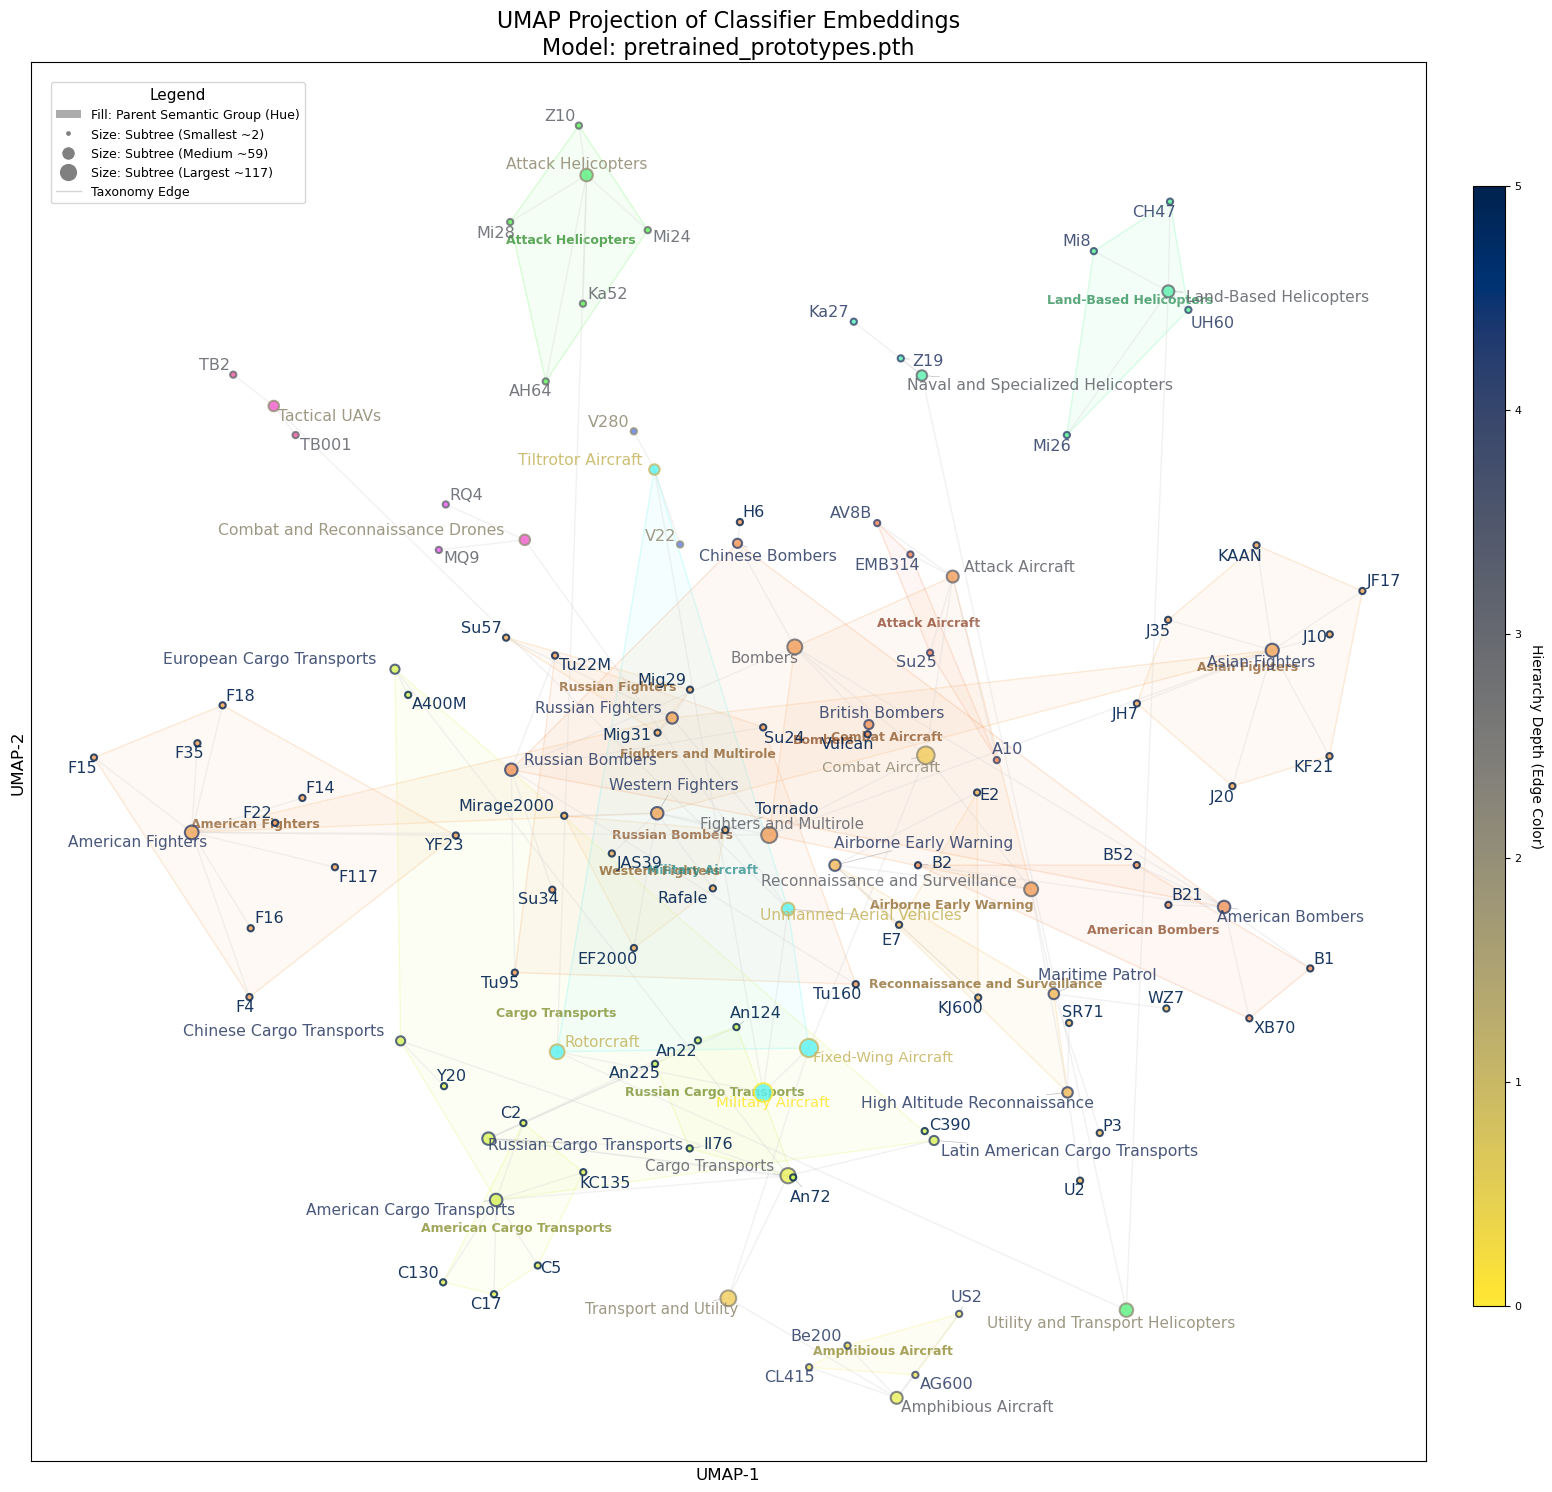

In [25]:
path = "../work_dirs/dino-4scale_r50_sep-eucl_hfl-3x_ecl_improved_8xb2_hier-aircraft/prototype_pretrain/pretrained_prototypes.pth"
plot_embeddings_umap(path, ann_file)

In [8]:
path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-cost-entail-full/epoch_36.pth"
plot_embeddings_umap(path, ann_file)


FileNotFoundError: [Errno 2] No such file or directory: '../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-cost-entail-full/epoch_36.pth'

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


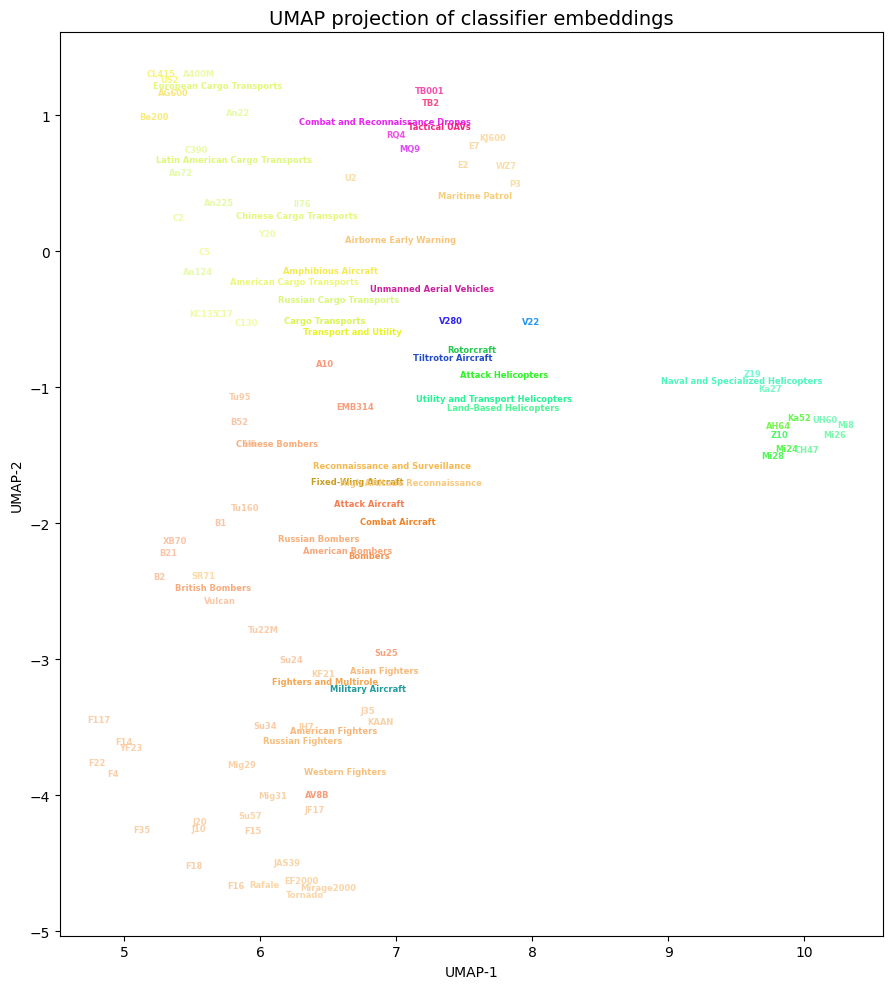

In [17]:
path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft/epoch_6.pth"
plot_embeddings_umap(path, ann_file)

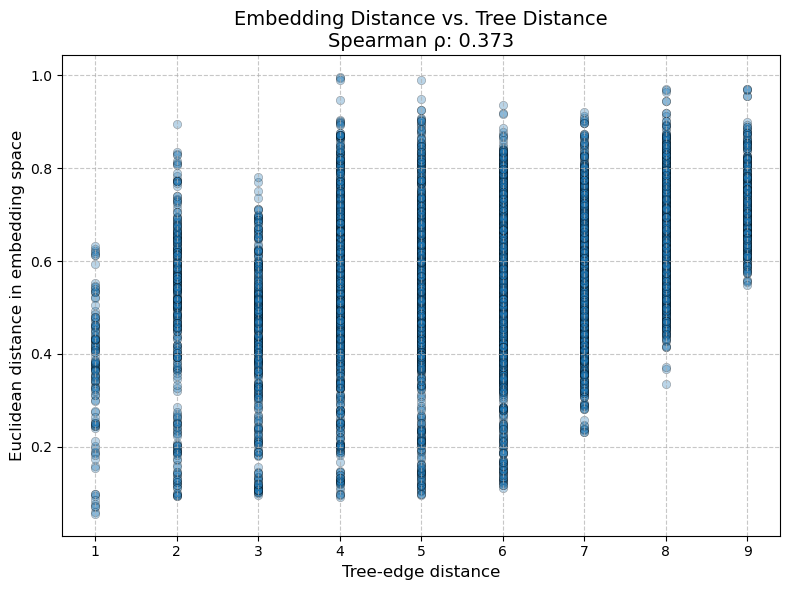

In [7]:
\
# Call the distance correlation plot function
# Using the same pretrained model path as one of the UMAP plots for consistency
pretrained_model_path = "../work_dirs/dino-4scale_r50_sep-eucl_hfl-3x_ecl_improved_8xb2_hier-aircraft/prototype_pretrain/pretrained_prototypes.pth"
plot_distance_correlation(pretrained_model_path, ann_file)

# You can also call it for other models:
# epoch_36_model_path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft-3x-cost-entail-full/epoch_36.pth"
# plot_distance_correlation(epoch_36_model_path, ann_file)

# epoch_6_model_path = "../work_dirs/dino-4scale_r50_improved_8xb2_hier-aircraft/epoch_6.pth"
# plot_distance_correlation(epoch_6_model_path, ann_file)
